# cDC analysis - UMAPs, differential expression, RNA velocity, and SCENIC 
Figure 4A,B,C,E, Ext F4A, (C, D - refer to DF notebooks)

- Author: DF, CW
- files needed: 7_cDC_cells.rds, Supplementary_Table_1.csv
- file outputs: For DEG analysis: cDC_RNA_analysis/F4C_volcano_df_mDC_vs_cDC1.csv, cDC_RNA_analysis/F4C_volcano_df_mDC_vs_cDC2.csv
- Last updated: 04/11/24

In [5]:
library('Seurat')
library('dplyr')
library('tidyr')
library('ggplot2')
library('Matrix')
library(tibble)
library('RColorBrewer')
library(ggplot2)
library(ggrepel)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




In [37]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /net/bmc-lab5/data/kellis/users/cbw3/conda/envs/r-kernel/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggrepel_0.9.5      RColorBrewer_1.1-3 tibble_3.2.1       Matrix_1.6-5      
[5] ggplot2_3.5.0      tidyr_1.3.1        dplyr_1.1.4        SeuratObject_5.0.1
[9] Seurat_4.3.0.1    

loaded via a namespace (and not attached):
  [1] ggbeeswarm_0.7.2       Rtsne_0.17             c

# Load cDC object

In [1]:
path_to_cDC_obj <- '/path_to_file/'

In [10]:
obj.cDC <- readRDS(paste0(path_to_cDC_obj, '7_RNA_cDC_cells.rds'))

In [11]:
obj.cDC

An object of class Seurat 
57840 features across 2160 samples within 3 assays 
Active assay: SCT (26545 features, 0 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap

## cDC UMAPs 

### 1. cDC subtypes - Figure 4A

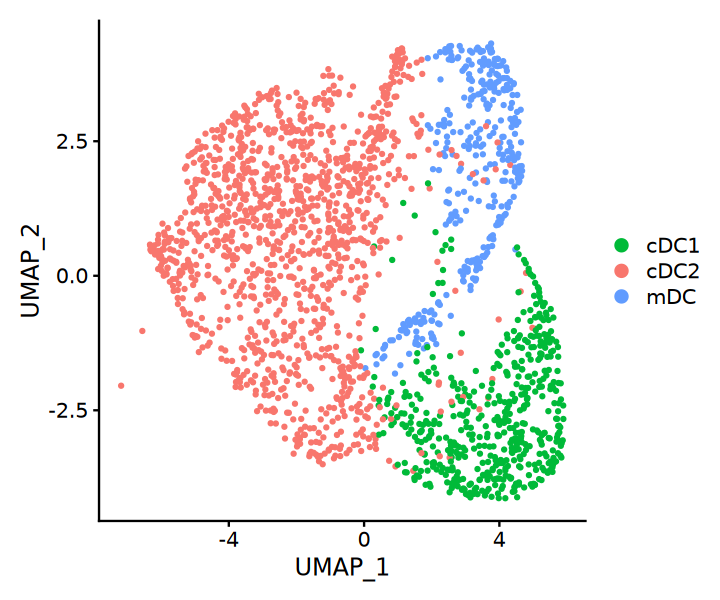

In [12]:
# Figure 4A 
options(repr.plot.height = 5, repr.plot.width = 6)
 # The height of the plot in inches
DimPlot(obj.cDC, reduction = "umap", cols =c('#00BA38', '#F8766D','#619CFF'))

### UMAP by patient sample - Extended Figure 4A

In [20]:
#add patient samples to cDC object 
clinical.metadata <- read.csv('/path_to_file/Supplementary_Table_1.csv', 
                             row.names = 'X')
sampleID.to.patientsample <- clinical.metadata[c('sample_ID_long', 'patient_sample')]

In [21]:
cDC.samples <- sampleID.to.patientsample[unique(sampleID.to.patientsample$sample_ID_long)%in% unique(obj.cDC$sample_ID_long),]

In [22]:
obj.cDC$patient_sample <- 'none'

In [23]:
for(sample in cDC.samples$sample_ID_long) {
    obj.cDC@meta.data[obj.cDC$sample_ID_long == sample,]$patient_sample <- cDC.samples[cDC.samples$sample_ID_long == sample,]$patient_sample
    }

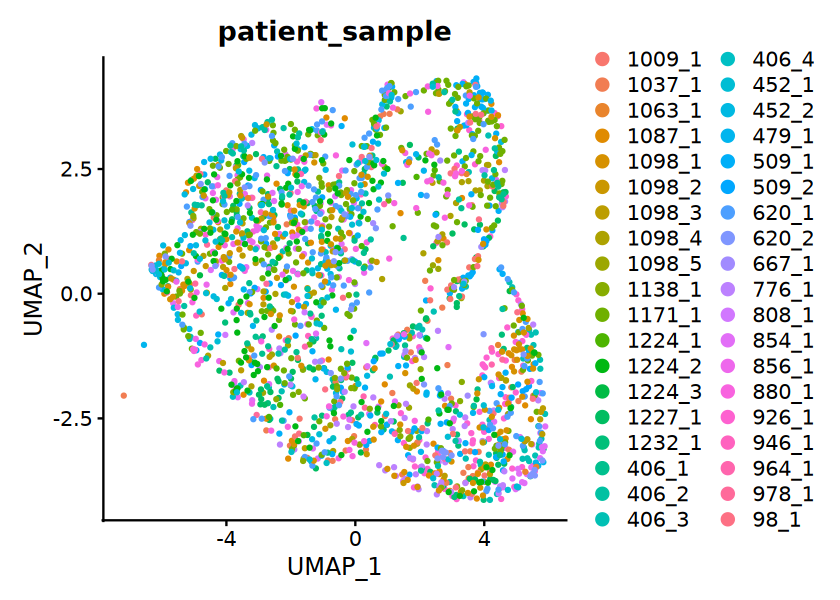

In [26]:
#EXTENDED FIGURE 4A
options(repr.plot.height = 5, repr.plot.width = 7)
p1 <- DimPlot(obj.cDC, reduction = "umap", group.by = "patient_sample",
              label.size = 3, repel = TRUE) + theme(aspect.ratio=1)
p1

## Violin Plot of cDC subtype markers - Figure 4B

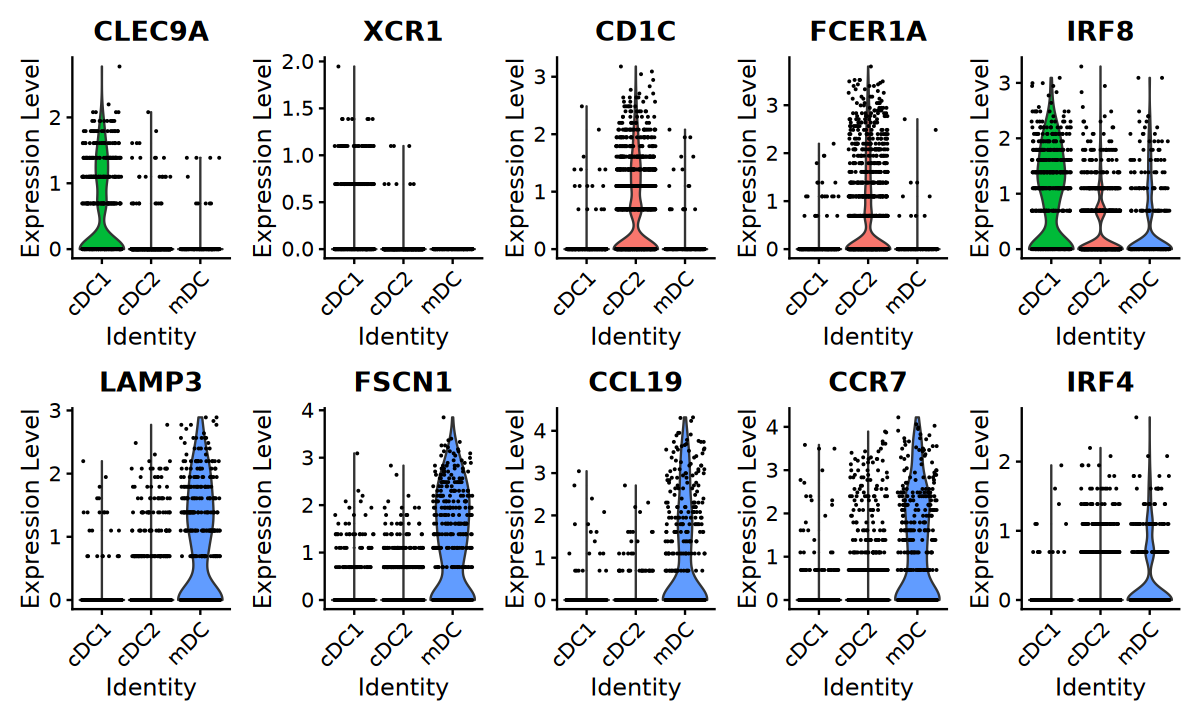

In [13]:
#FIGURE 4B
DefaultAssay(obj.cDC) <- "SCT"

options(repr.plot.width = 10, repr.plot.height = 6)
VlnPlot(obj.cDC, features = c('CLEC9A','XCR1', 'CD1C','FCER1A','IRF8','LAMP3','FSCN1', 'CCL19', 'CCR7', 
                         'IRF4'), ncol = 5, 
                            col =c('#00BA38', '#F8766D','#619CFF'))

# DEGs

In [14]:
Idents(obj) <- "Ident"
DefaultAssay(obj) <- "SCT"

In [32]:
## takes a while, jump ahead to volcano plots and read in volcano df files to produce results

In [7]:
#min.pct 0.1
mregDC.cDC1.markers <- FindMarkers(obj, ident.1 = 'mDC', ident.2 = 'cDC1', min.pct = 0.1, logfc.threshold=0.01, recorrect_umi=FALSE) #%>% filter (avg_log2FC >0)
mregDC.cDC2.markers <- FindMarkers(obj, ident.1 = 'mDC', ident.2 = 'cDC2', min.pct = 0.1, logfc.threshold=0.01 , recorrect_umi=FALSE) #%>% filter (avg_log2FC >0)

### Make dataframes to store markers for volcano plot 

In [26]:
# Volcano dataframe code 
make_volcano_df<- function(result,lf_cutoff, padj_cutoff){
    #select log fc and p value from result to visualize
    #col_names: c('log fold change', 'p-value') - may be named differently
    #lf_cutoff: cutoff for de genes
    #padj_cutoff: de genes are < padj_cutoff
    
    volcano_df <- result[,c('avg_log2FC', 'p_val_adj')]
    
    volcano_df <- volcano_df %>% arrange(p_val_adj)
    
    #get the gene name (probably the rowname of result)
    volcano_df$gene_symbol <- rownames(result)
    
    volcano_df$diffexpressed = 'NO'
    
    #diff expressed with up and down 
    volcano_df[volcano_df$avg_log2FC > lf_cutoff & volcano_df$p_val_adj < padj_cutoff,]$diffexpressed <- 'UP'
    volcano_df[volcano_df$avg_log2FC < -lf_cutoff & volcano_df$p_val_adj < padj_cutoff,]$diffexpressed <- 'DOWN'
    
    volcano_df$pval.adj <- volcano_df$p_val_adj + 1e-319
    
    #add gene symbols to only the top 20 genes on each side
    volcano_df$delabel <- NA
    volcano_df[volcano_df$diffexpressed == 'UP',][1:20,]$delabel <- volcano_df[volcano_df$diffexpressed == 'UP',][1:20,]$gene_symbol
    volcano_df[volcano_df$diffexpressed == 'DOWN',][1:20,]$delabel <- volcano_df[volcano_df$diffexpressed == 'DOWN',][1:20,]$gene_symbol
    
    #count number of upregulated and downregulated genes 
    num_up <- dim(volcano_df[volcano_df$diffexpressed == 'UP',])[1]
    num_down <- dim(volcano_df[volcano_df$diffexpressed == 'DOWN',])[1]
    print(paste0('number upregulated: ', num_up))
    print(paste0('number downregulated: ', num_down))

    #color the markers that are part of the 6 overlapping
    volcano_df[rownames(volcano_df) %in% c('KDM2B', 'DUSP22', 'FSCN1', 'IL15', 'GLS', 'CCR7'),]$delabel <- volcano_df[rownames(volcano_df) %in% c('KDM2B', 'DUSP22', 'FSCN1', 'IL15', 'GLS', 'CCR7'),]$gene_symbol

    volcano_df[rownames(volcano_df) %in% c('KDM2B', 'DUSP22', 'FSCN1', 'IL15', 'GLS', 'CCR7'),]$diffexpressed <- "intersect"
    
    return(list(volcano_df, num_up, num_down))
}

In [38]:
plot_volcano <- function(volcano_df, lf_cutoff, padj_cutoff, path, title, ymax = 10) {
    
    #options(repr.plot.width=15, repr.plot.height=15)
    
    # plot adding up all layers we have seen so far
    p <- ggplot(data=volcano_df, aes(x=avg_log2FC, y=-log10(pval.adj),col=diffexpressed)) + #, label=delabel)) +
        geom_point(alpha=0.7, size=0.7) +
        #geom_text(data = volcano_df, aes(label = delabel), size = 4) +
        scale_color_manual(values=c("DOWN" = "blue","NO" = "grey","UP" ="red", "intersect" = 'green')) +       
        #theme_bw() + 
        theme(panel.background = element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
             axis.line = element_line(colour = "black"), 
              axis.text= element_text(size = 8), plot.title = element_text(size = 10)) +
        geom_text_repel(aes(label = delabel), max.overlaps=60, size = 4, segment.alpha = 0.4, min.segment.length = 1) +
        geom_vline(xintercept=lf_cutoff,lty=4,col="black",lwd=0.8) + 
        geom_hline(yintercept = -log10(padj_cutoff),lty=4,col="black",lwd=0.8) + ggtitle(title) + xlim(-4, 4)
            #ylim(0, ymax)  + 

    return(p)

}

#### mDC vs cDC1

Warning message:
“Removed 2926 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


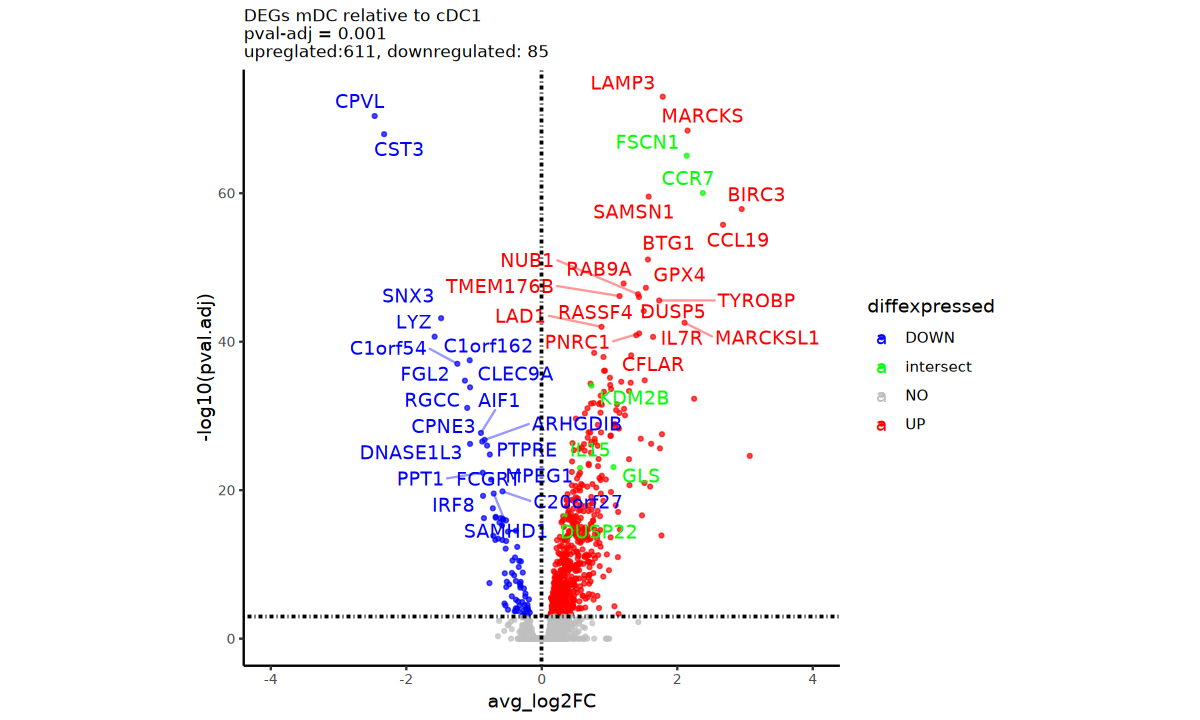

In [40]:
#cutoffs: padj < 0.001
volcano_res <- make_volcano_df(mDC.cDC1.markers, 0, 0.001)
volcano_df_mDC_cDC1 <- volcano_res[[1]]
mDC_cDC1_num_up <- volcano_res[[2]]
mDC_cDC2_num_down <- volcano_res[[3]]

#Plot volcano 
plot_volcano(volcano_df_mDC_cDC1, 0, 0.001, '/home/cbw3/data/figure_generation/Figure4/ExtF4C.pdf', 
                 paste0('DEGs mDC relative to cDC1 \npval-adj = 0.001 \nupreglated:', mDC_cDC1_num_up , ', downregulated: ', 
                     mDC_cDC2_num_down), ymax = -log10(min(volcano_df$pval.adj))) + theme(aspect.ratio = 1)

#write.csv(volcano_df_mDC_cDC1, '/path_to_file/F4C_volcano_df_mDC_vs_cDC1.csv')
#ggsave('/path_to_file/F4C_mDC_cDC1_volcano_plot.pdf')

#### mDC vs cDC2

Warning message:
“Removed 3541 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


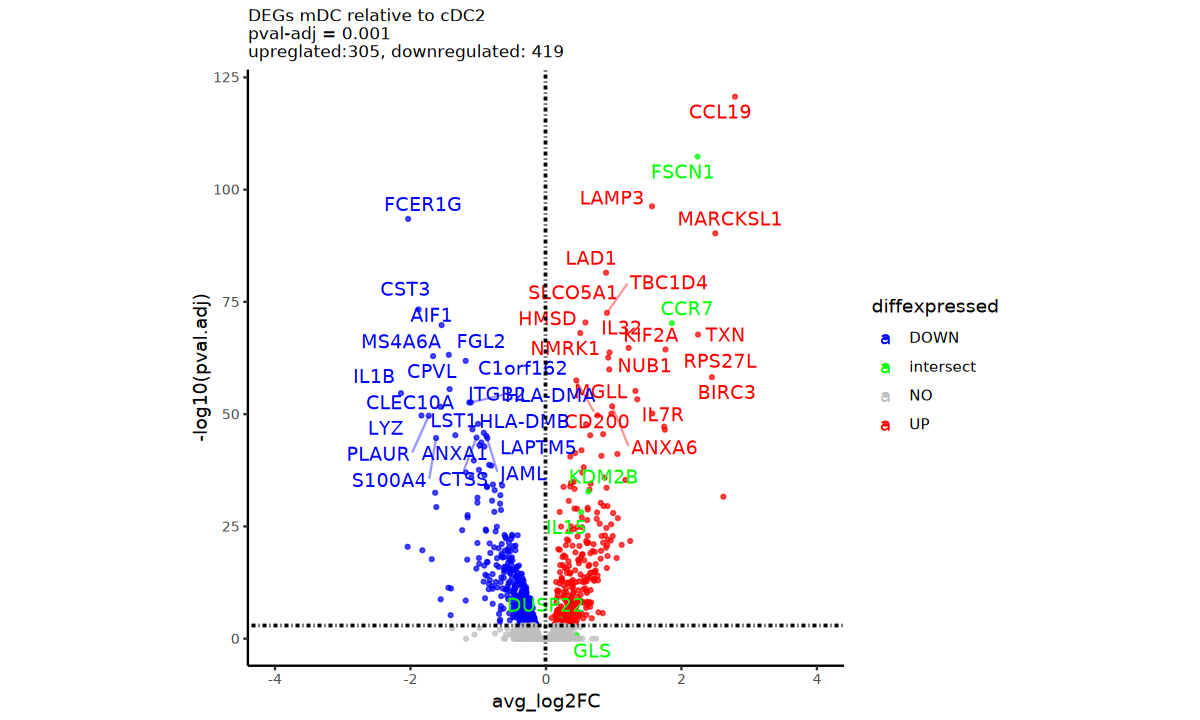

In [43]:
volcano_res <- make_volcano_df(mDC.cDC2.markers, 0, 0.001)
volcano_df_mDC_cDC2 <- volcano_res[[1]]
mDC_cDC2_num_up <- volcano_res[[2]]
mDC_cDC2_num_down <- volcano_res[[3]]


plot_volcano(volcano_df_mDC_cDC2, 0, 0.001, '/home/cbw3/data/figure_generation/Figure4/ExtF4C.pdf', 
                 paste0('DEGs mDC relative to cDC2 \npval-adj = 0.001 \nupreglated:', mDC_cDC2_num_up, ', downregulated: ', 
                     mDC_cDC2_num_down), ymax = -log10(min(volcano_df$pval.adj))) + theme(aspect.ratio = 1)

#write.csv(volcano_df_mDC_cDC2, './F4C_volcano_df_mDC_vs_cDC2.csv')
#ggsave('./F4C_mDC_cDC1_volcano_plot.pdf')

## CellRank plot - Extended Figure 4C 

In [ ]:
# see notebook from D.F. 

## SCENIC RSS scores - Extended Figure 4D

In [21]:
library(ggplot2)
library(ggrepel)

In [44]:
cDC.RSS <- read.csv('/home/cbw3/data/figure_generation/final_notebooks/cDC_RSS_score.csv', row.names = 'X')

In [47]:
colnames(cDC.RSS)[4] <- 'mregDC'

In [51]:
#from D.F.
cDC.RSS$Regulon_Specificity_Score <-cDC.RSS[['mregDC']]
cDC.RSS <-cDC.RSS  %>%
mutate(rank = rank(-cDC.RSS$Regulon_Specificity_Score),
           label = ifelse(rank <=20, row, ''),
            color = ifelse(rank <=20, 'red', ''))

p <- ggplot(cDC.RSS, aes(x = rank, y = Regulon_Specificity_Score, color = color, label = label))+
    geom_point()+
    scale_color_manual(values=c('black',"red"))+
    theme_classic()  + ylim(0, 1.00) +
        theme(legend.position = "none")+
    theme(text = element_text(size = 8)) +
     geom_text_repel(force = 40, # do not pull toward data points
    force_pull = 0,
     nudge_y      = -0.5,
     #nudge_x = 200,
    direction    = "x",
    angle        = 90,
    hjust        = 0,
    segment.size = 0.2,
    max.iter = 1e4, max.time = 1,
                     size = 2)

Warning message:
“Removed 64 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 378 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


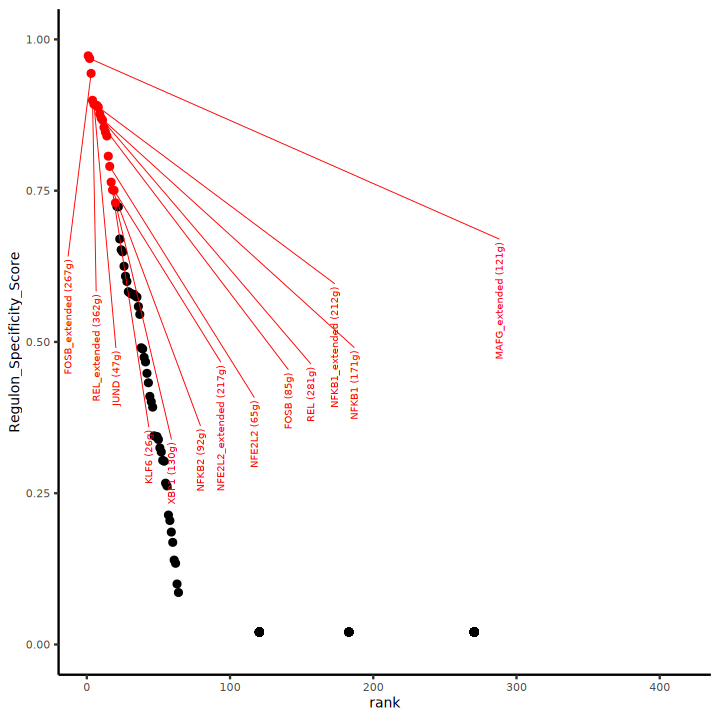

In [52]:
options(repr.plot.width = 6, repr.plot.height = 6)
p